In [18]:
import os
import tensorflow as tf

# 데이터셋 경로 설정
dataset_path = '/kaggle/input/utkface-new/crop_part1'

# 연령대 분류 함수
def classify_age(age):
    if age <= 2:
        return 0  # 영아
    elif age <= 5:
        return 1  # 유아
    elif age <= 12:
        return 2  # 아동
    elif age <= 19:
        return 3  # 청소년
    elif age <= 39:
        return 4  # 청년
    elif age <= 59:
        return 5  # 중년
    else:
        return 6  # 노년

# 데이터 로드 함수
def load_dataset(dataset_path):
    image_paths = []
    age_labels = []
    gender_labels = []

    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg'):
            age = int(filename.split('_')[0])
            gender = int(filename.split('_')[1])

            image_paths.append(os.path.join(dataset_path, filename))
            age_labels.append(classify_age(age))
            gender_labels.append(gender)

    return image_paths, age_labels, gender_labels

# 데이터 로드
image_paths, age_labels, gender_labels = load_dataset(dataset_path)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, age_labels, gender_labels))


In [20]:
# 데이터 전처리 함수
def preprocess_data(image_path, age_label, gender_label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    age_label = tf.one_hot(age_label, depth=7)  # 연령대 클래스 수에 맞게 one-hot 인코딩
    gender_label = tf.one_hot(gender_label, depth=2)  # 성별 클래스 수에 맞게 one-hot 인코딩
    return image, (gender_label, age_label)  # 성별 레이블과 연령대 레이블을 튜플로 반환

# 데이터 전처리 적용
dataset = dataset.map(preprocess_data)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# 배치 크기 설정
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# 데이터 증강
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", seed=42),
  tf.keras.layers.RandomRotation(0.2, seed=42),
  tf.keras.layers.RandomZoom(0.2, seed=42),
  tf.keras.layers.RandomContrast(0.3, seed=42),
  tf.keras.layers.RandomBrightness(0.3, seed=42),
  tf.keras.layers.GaussianNoise(0.01, seed=42),
])

In [21]:
# 데이터 증강
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", seed=42),
  tf.keras.layers.RandomRotation(0.2, seed=42),
  tf.keras.layers.RandomZoom(0.2, seed=42),
  tf.keras.layers.RandomContrast(0.3, seed=42),
  tf.keras.layers.RandomBrightness(0.3, seed=42),
  tf.keras.layers.GaussianNoise(0.01, seed=42),
])

In [22]:
# MobileNet 모델 생성
ALPHA = 0.25
DROPOUT = 0.10

mobilenet_025_224 = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(224, 224, 3),
    alpha=ALPHA,
    dropout=DROPOUT,
    weights='imagenet',
    pooling='avg',  # pooling을 'avg'로 설정하여 GlobalAveragePooling2D를 대신함
    include_top=False
)

# 최종 모델 생성
num_classes = 2  # 성별 클래스 수 (남, 여)
age_range_classes = 7  # 나이대 클래스 수 (영아, 유아, 아동, 청소년, 청년, 중년, 노년)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = mobilenet_025_224(x)
gender_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='gender')(x)
age_output = tf.keras.layers.Dense(age_range_classes, activation='softmax', name='age')(x)

model = tf.keras.Model(inputs=inputs, outputs=[gender_output, age_output])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'gender': 'categorical_crossentropy',
        'age': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [23]:
# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
    ),
]

# 모델 학습
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
)

# 모델 평가
loss, gender_loss, age_loss, gender_accuracy, age_accuracy = model.evaluate(test_dataset)
print("Test loss:", loss)
print("Test gender loss:", gender_loss)
print("Test age loss:", age_loss)
print("Test gender accuracy:", gender_accuracy)
print("Test age accuracy:", age_accuracy)

# 모델 저장
model.save('age_gender_model.h5')

Epoch 1/10


I0000 00:00:1711343895.216048      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


245/245 [==============================] - ETA: 0s - loss: 2.6081 - gender_loss: 0.7256 - age_loss: 1.8825 - gender_accuracy: 0.5431 - age_accuracy: 0.2864
Epoch 1: val_loss improved from inf to 3.01312, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 45s 117ms/step - loss: 2.6081 - gender_loss: 0.7256 - age_loss: 1.8825 - gender_accuracy: 0.5431 - age_accuracy: 0.2864 - val_loss: 3.0131 - val_gender_loss: 0.7352 - val_age_loss: 2.2780 - val_gender_accuracy: 0.5297 - val_age_accuracy: 0.2935
Epoch 2/10
245/245 [==============================] - ETA: 0s - loss: 2.3510 - gender_loss: 0.6606 - age_loss: 1.6905 - gender_accuracy: 0.6060 - age_accuracy: 0.3399
Epoch 2: val_loss improved from 3.01312 to 2.33453, saving model to best_model.h5
245/245 [==============================] - 14s 57ms/step - loss: 2.3510 - gender_loss: 0.6606 - age_loss: 1.6905 - gender_accuracy: 0.6060 - age_accuracy: 0.3399 - val_loss: 2.3345 - val_gender_loss: 0.6577 - val_age_loss: 1.6769 - val_gender_accuracy: 0.5920 - val_age_accuracy: 0.3395
Epoch 3/10
245/245 [==============================] - ETA: 0s - loss: 2.2466 - gender_loss: 0.6367 - age_loss: 1.6100 - gender_accuracy: 0.6204 - age_accuracy: 0.3691
Epoch 3: 

1/1 [==============================] - 0s 20ms/step


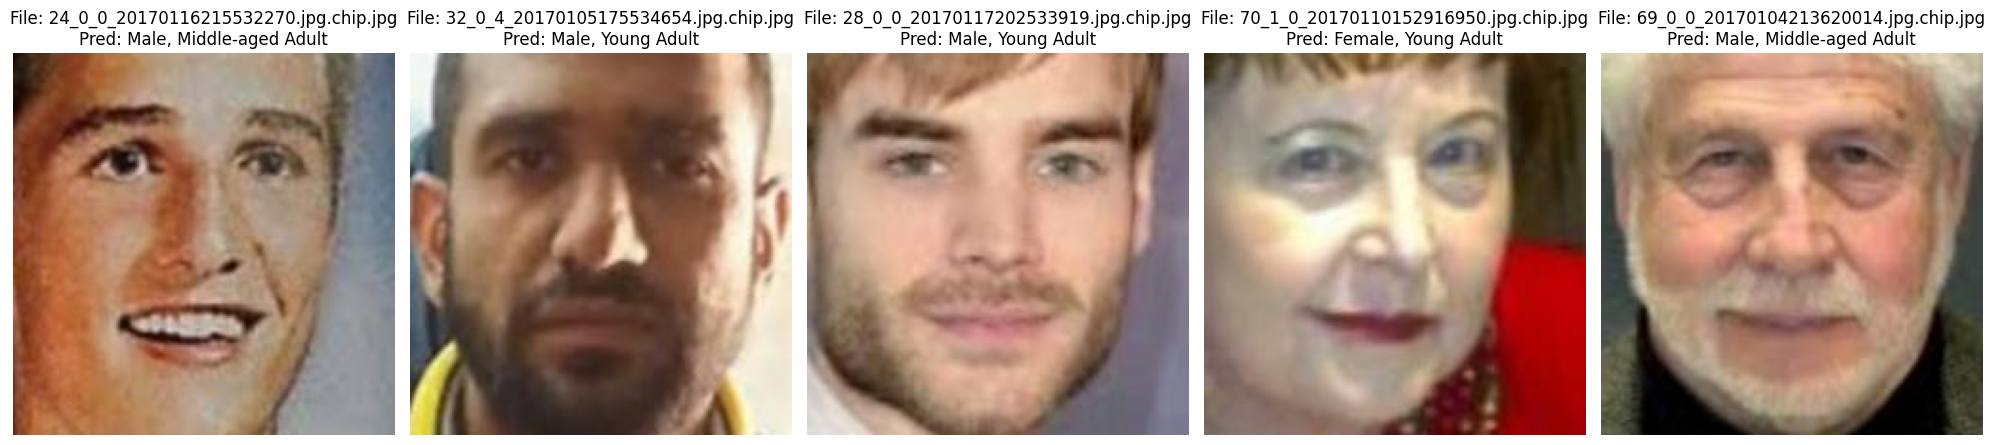

In [37]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# UTKFace 데이터셋 경로
dataset_path = '/kaggle/input/utkface-new/UTKFace'

# 랜덤으로 20개의 이미지 선택
image_files = random.sample(os.listdir(dataset_path), 5)

# 이미지 로드 및 전처리
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    return img

# 모델 로드
loaded_model = tf.keras.models.load_model('best_model.h5')

# 예측 결과 해석을 위한 레이블
gender_labels = ['Male', 'Female']
age_labels = ['Infant', 'Toddler', 'Child', 'Teenager', 'Young Adult', 'Middle-aged Adult', 'Senior Adult']

# 이미지 출력 및 예측 결과 표시
plt.figure(figsize=(20, 20))
for i, image_file in enumerate(image_files, start=1):
    image_path = os.path.join(dataset_path, image_file)
    
    try:
        # 원본 이미지 로드
        image = Image.open(image_path)
        
        # 이미지 전처리 및 예측 수행
        preprocessed_image = preprocess_image(image_path)
        gender_preds, age_preds = loaded_model.predict(preprocessed_image)
        
        # 예측 결과 해석
        pred_gender = gender_labels[np.argmax(gender_preds)]
        pred_age = age_labels[np.argmax(age_preds)]
        
        # 이미지 출력
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"File: {image_file}\nPred: {pred_gender}, {pred_age}")
        
    except Exception as e:
        print(f"Error processing file {image_file}: {str(e)}")
        continue

plt.tight_layout()
plt.show()

In [41]:
import tensorflow as tf

def reprPresentative_dataset():
    for image, _ in val_ds_96_96.take(100):
        yield [tf.image.resize(image, (224, 224))]  # 입력 크기를 (224, 224)로 조정

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32

tflite_quant_model = converter.convert()

with open('age_gender_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

/opt/conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 60, Total Ops 99, % non-converted = 60.61 %
 * 60 ARITH ops

- arith.constant:   60 occurrences  (f32: 58, i32: 2)



  (f32: 14)
  (f32: 13)
  (f32: 2)
  (f32: 1)
  (f32: 4)
  (f32: 2)
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: FLOAT32


In [42]:
import os
import subprocess

# TensorFlow Lite 모델을 C++ 헤더 파일로 변환
with open('age_gender_model.h', 'w') as f:
    f.write('alignas(8) const unsigned char tflite_model[] = {\n')
    process = subprocess.Popen(['xxd', '-i', 'age_gender_model.tflite'], stdout=subprocess.PIPE)
    while True:
        output = process.stdout.readline().decode('utf-8')
        if output == '' and process.poll() is not None:
            break
        if output:
            f.write(output)
    f.write('};\n')
    f.write('const int tflite_model_len = {};\n'.format(os.path.getsize('age_gender_model.tflite')))

print("TensorFlow Lite model converted to C++ header file.")

TensorFlow Lite model converted to C++ header file.


In [43]:
// age_gender_model.h 파일을 포함
#include "age_gender_model.h"

// TensorFlow Lite 인터프리터 생성
std::unique_ptr<tflite::Interpreter> interpreter;
tflite::InterpreterBuilder builder(tflite::GetModel(tflite_model), resolver);
builder(&interpreter);

// 입력 및 출력 텐서 설정
interpreter->AllocateTensors();
// ...

SyntaxError: invalid syntax (5681727.py, line 1)

In [40]:
import tensorflow as tf

def image_resize_96_96(x, y):
    x = tf.image.resize(x, (96, 96))
    x = tf.expand_dims(x, axis=0)
    return x, y

val_ds_96_96 = val_dataset.unbatch().map(image_resize_96_96)

def representative_dataset():
    for image, _ in val_ds_96_96.take(100):
        yield [tf.image.resize(image, (224, 224))]  # 입력 크기를 (224, 224)로 조정

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32

tflite_quant_model = converter.convert()

with open('age_gender_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

interpreter = tf.lite.Interpreter(model_path='age_gender_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# 테스트 이미지 선택
test_image_path = random.choice(image_files)
test_image = Image.open(os.path.join(dataset_path, test_image_path))
test_image = test_image.resize((224, 224))  # 입력 크기를 (224, 224)로 조정
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image.astype(np.uint8)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()

gender_output = interpreter.get_tensor(output_details[0]['index'])
age_output = interpreter.get_tensor(output_details[1]['index'])

pred_gender = gender_labels[np.argmax(gender_output)]
pred_age = age_labels[np.argmax(age_output)]

plt.figure(figsize=(8, 8))
plt.imshow(test_image[0])
plt.axis('off')
plt.title(f"File: {test_image_path}\nPred: {pred_gender}, {pred_age}")
plt.show()

/opt/conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 60, Total Ops 99, % non-converted = 60.61 %
 * 60 ARITH ops

- arith.constant:   60 occurrences  (f32: 58, i32: 2)



  (f32: 14)
  (f32: 13)
  (f32: 2)
  (f32: 1)
  (f32: 4)
  (f32: 2)
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: FLOAT32


Input details: [{'name': 'serving_default_input_10:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.007843137718737125, 127), 'quantization_parameters': {'scales': array([0.00784314], dtype=float32), 'zero_points': array([127], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 96, 'shape': array([1, 7], dtype=int32), 'shape_signature': array([-1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:1', 'index': 99, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'qua

IndexError: list index out of range

In [ ]:
age_labels